In [1]:
import numpy as np
import matplotlib.pyplot as plt

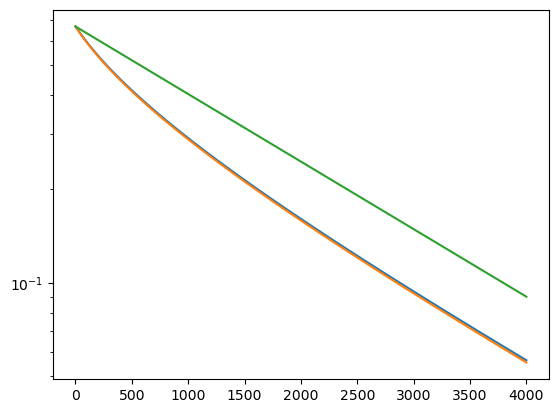

In [27]:
ka = 2
kd = 0.01
pt = 1
k1 = .1

def dpl2(pl):
    return -pl*kd*k1/(k1+ka*(pt-pl))

def pl_flux(pl, lm):
    return ka*(pt - pl)*lm - kd*pl

#integrator settings
dt = 0.02
tmax = 200000

#initial conditions
lm = 0.01

pl = pt*lm/(lm+kd/ka)
pl2 = pl

#data collection
pl2_trj = [pl2]

pl_trj = [pl]
lm_trj = [lm]
t_trj = [0]

analytic = [pl]

for t in range(tmax):
    pl += pl_flux(pl,lm)*dt
    lm += (-k1*lm - pl_flux(pl,lm))*dt

    t_trj.append((t+1)*dt)
    pl_trj.append(pl)
    lm_trj.append(lm)

    pl2 += dpl2(pl2)*dt

    pl2_trj.append(pl2)

    analytic.append(pl_trj[0]*np.exp(-t*dt*kd*k1/(ka*pt)))

plt.plot(t_trj, pl_trj)
#plt.plot(t_trj, lm_trj)

plt.plot(t_trj, pl2_trj)

plt.plot(t_trj, analytic)

plt.yscale("log")

In [ ]:
ka*pt must exceed k1 for the results to be useful, but large ka*pt also delays the time when it becomes a reliable approximation.